# Wrangling III 

In this tutorial, we'll round out our focus on data wrangling by looking 

- handling duplicate values
- data transformations

## Preliminaries

As usual, we'll load some libraries we'll be likely to use.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Now we'll get set up to work by

- loading the cancer data and cleaning it up (as before)
- trim out some columns so we can look at the data frame more easily
- shorten up some of the column names to save ourselves some typing

Let's reuse our function to do the loading and cleaning.

In [2]:
def bcd_load_clean():
    bcd = pd.read_csv('./data/breast_cancer_data.csv')
    bcd['patient_id'] = bcd['patient_id'].astype('string')
    bcd['doctor_name'] = bcd['doctor_name'].str.split().str[1]
    bcd['bare_nuclei'] = bcd['bare_nuclei'].replace('?', '')
    bcd['bare_nuclei'] = pd.to_numeric(bcd['bare_nuclei'])
    
    return bcd

In [3]:
bcd = bcd_load_clean()

Make a little version with just two numeric columns to play with.

In [4]:
bcd2 = bcd[['patient_id', 'clump_thickness', 'bland_chromatin', 'class']].copy()

Let's give the columns shorter names to save some typing.

In [5]:
bcd2 = bcd2.rename(columns={'clump_thickness': 'thick',
                            'bland_chromatin': 'chrom',
                            'patient_id': 'id'})

## Duplicate entries

As we have already seen, datasets can contain strange things that we have to overcome prior to analysis. One of the most common issues in a dataset are duplicate entries. These are common with large datasets that have been transcribed by humans at some point. Humands get bored, lose their place, etc.

---

Let's look at the shape of our cancer data frame (remember data frames have a `shape` attribute).

In [8]:
bcd2.shape

(699, 4)

---

Now let's look at the number of unique entries using the `nunique()` data frame method; this will return the number of distinct values in each column.

In [12]:
bcd2.nunique()

id       645
thick     10
chrom     10
class      2
dtype: int64

---

So we can see that, while there are 699 observations in our data, there are only 645 unique patient ids. This tells us that several patients have multiple entries. These could be from patients making multiple visits to the doctor, or they could be a mistakes, or some combination thereof.

We can find out which rows – which entire observations – are identical with the `duplicated()` method. 

In [13]:
bcd2.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
694    False
695    False
696    False
697    False
698     True
Length: 699, dtype: bool

That's not terribly helpful by itself, but...

---

In the cell below, count the number of duplicated rows (remember a True is a 1).

In [16]:
bcd2.duplicated().sum()

12

---

We can also use the output of `.duplicated()` to do logical indexing to see the observations that have duplicates. Do that in the cell below.

In [27]:
bcd2[bcd2.duplicated()]

,id,thick,chrom,class
208,1218860,1.0,3.0,benign
253,1100524,6.0,7.0,malignant
254,1116116,9.0,3.0,malignant
258,1198641,3.0,3.0,benign
272,320675,3.0,7.0,malignant
322,733639,3.0,3.0,benign
338,704097,1.0,2.0,benign
443,734111,1.0,1.0,benign
561,1321942,5.0,3.0,benign
684,466906,1.0,1.0,benign


---

This is promising but, if we look at what is listed, we don't actually see any duplicates. So what is `duplicates()` doing?

---

Use the cell below to get help on `duplicated()` using `help()` or `?`.

In [ ]:
bcd2.duplicated()?

---

... we can see that it has a "keep" argument. By default, `duplicated()` it gives us the *first* instance of any duplicated rows. We can make it show all the rows with `keep=False`.

Go ahead and do that in the cell below.

In [24]:
bcd2.duplicated(keep=False)

0      False
1      False
2      False
3      False
4      False
       ...  
694    False
695    False
696    False
697     True
698     True
Length: 699, dtype: bool

---

Hm. That's somewhat helpful. If we look near the bottom, we see that the last 5 or so duplicates occur in successive rows, perhaps indicating a data entry mistake. Perhaps looking at the data sorted by patient ID would be more helpful.

---

In the cell below, use the the `.sort_values()` method to look at our duplicates sorted by ID.

In [39]:
bcd2.sort_values(by=['id'])

,id,thick,chrom,class
0,1000025,5.0,3.0,benign
485,1002025,1.0,1.0,benign
382,1002504,3.0,3.0,benign
1,1002945,5.0,3.0,benign
2,1015425,3.0,3.0,benign
...,...,...,...,...
364,896404,2.0,3.0,benign
365,897172,2.0,NaN,benign
697,897471,4.0,10.0,malignant
698,897471,4.0,10.0,malignant


So most of the duplicates occur in adjacent rows, but others do not. Perhaps we should check and see if the same patients occur multiple times with different measurements, indicating multiple visits to the doctor. 

---

Use the cell below and the `subset` argument to `duplicated()` to look at multiple entries for any patients that have them.

In [58]:
bcd2.duplicated(subset = 'chrom')

0      False
1       True
2       True
3       True
4       True
       ...  
694     True
695     True
696     True
697     True
698     True
Length: 699, dtype: bool

---

Now, in the cell below, do the same thing but sort the output by patient ID.

In [59]:
bcd2.duplicated(subset = 'id')

0      False
1      False
2      False
3      False
4      False
       ...  
694    False
695    False
696    False
697    False
698     True
Length: 699, dtype: bool

---

So it looks like patients do come in multiple times and the values can change between visits.

We can look at repeat patient's number of visits directly if we want. We'll take advantage of the fact that the `.size` of a `groupby()` object returns the number of rows for each group.

In [60]:
repeat_patients = bcd2.groupby('id').size().sort_values(ascending =False)

In [61]:
repeat_patients

id
1182404    6
1276091    5
1198641    3
1299596    2
1158247    2
          ..
1200892    1
1200952    1
1201834    1
1201870    1
95719      1
Length: 645, dtype: int64

---

So one patient came in 6 times.

---

Use the cell below look at the data for the patient with 6 visits.

In [62]:
bcd2[bcd2['id'] == '1182404']

,id,thick,chrom,class
136,1182404,4.0,2.0,benign
256,1182404,3.0,1.0,benign
257,1182404,3.0,2.0,benign
265,1182404,5.0,3.0,benign
448,1182404,1.0,1.0,benign
497,1182404,4.0,1.0,benign


---

So it appears that some patients have multiple legitimate entries in the data frame.

---

If you were put in charge of analyzing these data, what would you do with duplicate observations in this data frame, and why?

I would average them together or eliminate the patient from the dataset, depending on what I am trying to study. Since a pretty low number of patients have duplicate visits, it may be best just to omit them from the study.

---

## Transforming data

Sometimes we wish to apply a transform to data by pushing each data value through some function. Common transformations are unit conversions (miles to kilometers, for example), log or power transformations, and normalizing data (for example, converting data to z-scores).

### Transforming data with a built-in function

Consider the following data...

In [103]:
df = pd.DataFrame({'x': range(6),
                   'y': [0.1, 0.9, 4.2, 8.7, 15.9, 26]})

In [104]:
df

,x,y
0,0,0.1
1,1,0.9
2,2,4.2
3,3,8.7
4,4,15.9
5,5,26.0


---

Plot the data (y vs. x) (seaborn's `relplot()` is handy).

In [105]:
%matplotlib inline

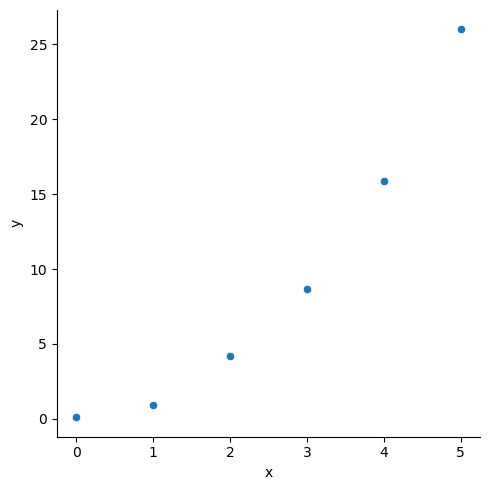

In [106]:
# plot y vs. x

sns.relplot(df, x='x', y ='y')

---

These data look non-linear, like they are following a power law. If that's true, we should get a straight line if we plot the log of the values against one another. In order to get these values, we will use the `transform()` method to convert the values into their logs.

In [107]:
df_trans = df.copy()
df_trans['y'] = df['y'].transform(np.log10)
df_trans['x'] = df['x'].transform(np.log10)

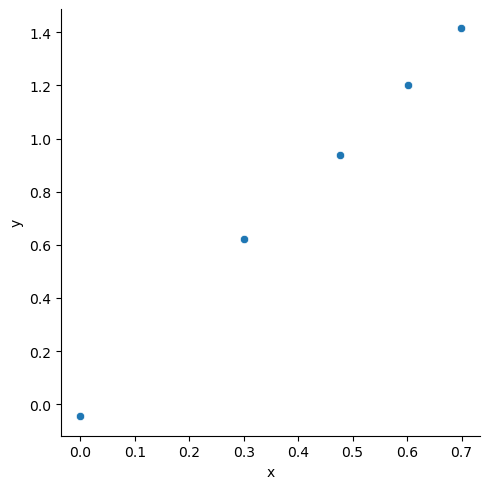

In [108]:
# plot new y vs. new x
sns.relplot(df_trans, x='x', y ='y')

Sure enough. The slope of the line should tell us the exponent of the power law, and it looks to be about 2. If that's the case, then transforming the original y-values with a square-root function should also produce a straight line.

In the cells below, use `transform()` to get the square root of the original y values, and plot them against the x values.

In [109]:
# get sqrts
df_sqrt = df.copy()
df_trans['y'] = df['y'].transform(np.sqrt)

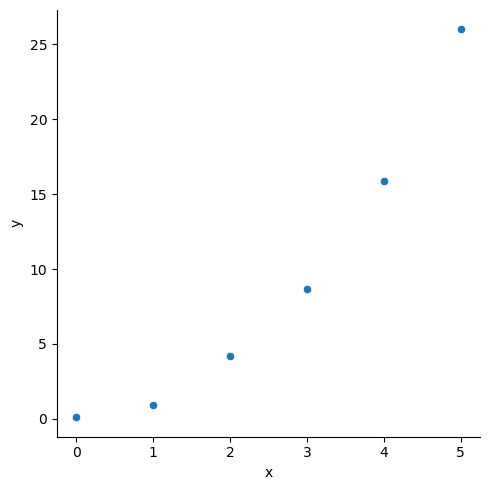

In [110]:
#plot
sns.relplot(df_sqrt, x='x', y ='y')

---

We could also transform our cancer data. In the cell below, create a new data frame in which the numeric values are the natural log of the original values.

In [91]:
# compute log vals
df_log = df.copy()
df_trans['y'] = df['y'].transform(np.log)
df_trans['x'] = df['x'].transform(np.log)

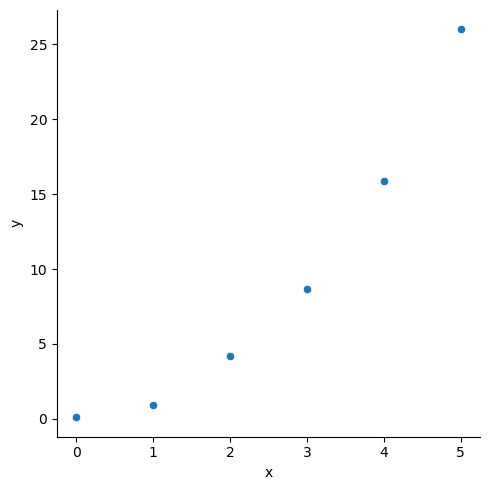

In [92]:
sns.relplot(df_log, x='x', y ='y')

---

### Applying a custom function to data

A great thing about `transform()` (and some other data frame methods) is you can use your own fuctions, not just built in ones.

For `transform()`, the only requirement is that your function

- be able to take a data frame as input
- produce output the same size as the input, or
- produce a single value

Here's a function to "center" data by subtracting the mean from each value. 

In [95]:
def center_data(grp):
    grp_mean = grp.mean(numeric_only = True)
    
    grp = (grp - grp_mean)
    
    return grp

---

In the cell below, use our new function to create a new version of our cancer data frame with the mean removed from each group of data. The `.transform()` method works column-by-column, so you don't need to worry about grouping the data.

In [131]:
bcd3 = bcd2[["thick", "chrom"]].transform(center_data)
bcd3

,thick,chrom
0,0.583095,-0.447482
1,0.583095,-0.447482
2,-1.416905,-0.447482
3,1.583095,-0.447482
4,-0.416905,-0.447482
...,...,...
694,-1.416905,-2.447482
695,-2.416905,-2.447482
696,0.583095,4.552518
697,-0.416905,6.552518


---

Confirm this worked by computing the mean for each column of your transformed data.

In [125]:
bcd3.mean(numeric_only = True)

chrom    0.000000e+00
thick    4.071878e-17
dtype: float64

---

In the cells below, write a function to convert the cancer data to z-scores, and use your new function to convert the numeric columns of our cancer data frame.

In [133]:
# my z-score function!
def zscore_data(grp):
    grp_mean = grp.mean(numeric_only = True)
    
    grp_sd = grp.std(numeric_only = True)
    
    grp = ((grp - grp_mean)/(grp_sd))
 
    return grp

In [134]:
# run transform() with my function

bcd4 = bcd2[["thick", "chrom"]].transform(zscore_data)

In [135]:
# look at the transformed data
bcd4

,thick,chrom
0,0.206942,-0.183305
1,0.206942,-0.183305
2,-0.502864,-0.183305
3,0.561845,-0.183305
4,-0.147961,-0.183305
...,...,...
694,-0.502864,-1.002577
695,-0.857766,-1.002577
696,0.206942,1.864876
697,-0.147961,2.684148


In [138]:
# see what the means are
bcd4.mean(numeric_only = True)

thick    3.053909e-17
chrom    6.134182e-17
dtype: float64

In [141]:
# see what the ... are
bcd4.mode(numeric_only = True)

,thick,chrom
0,-1.212669,-0.592941


---

#### lambda functions

Lambda functions, also know as anonymous functions, are short, one-off functions that are often used in situation in which ***all*** you need the function for is get passed to a method such as `transform()`

While the structure of a normal function is:

In [ ]:
def func_name(input_arg) :
    caluculations
    ret_val = more calculations
    
    return ret_val

The structure of a lambda function is:

In [ ]:
lambda input_arg : calculation of ret_val

Here's how we would compute z-scores using a lambda function:

In [145]:
trans_data = bcd2[['thick', 'chrom']].transform(
    lambda col_vals: (col_vals - col_vals.mean()) / col_vals.std()
)

Note that the entire lambda function is the one and only input to `transform()`.

---

In the cell below, confirm that the lambda function method worked.

In [146]:
trans_data

,thick,chrom
0,0.206942,-0.183305
1,0.206942,-0.183305
2,-0.502864,-0.183305
3,0.561845,-0.183305
4,-0.147961,-0.183305
...,...,...
694,-0.502864,-1.002577
695,-0.857766,-1.002577
696,0.206942,1.864876
697,-0.147961,2.684148


---

For very simple transformations, using a lambda function makes a lot of sense. For more complicated transformations, we'd probably want to just create a regular function, or the code could become unreadable. 

How complicated is too complicated? That's up to you, but anything more complicated than applying an offset and a scale factor (like computing a z-score), probably deserves its own function.

---

In the cell below, transform the numeric cancer data so the values range from 0 to 1 using a lambda function. You can assume that the maximum value is 10 and the minimum value is 1.

In [195]:
zero_one = bcd2[['thick', 'chrom']].transform(
    lambda col_vals: (col_vals - col_vals.min())/(col_vals.max() - col_vals.min()))

In [196]:
zero_one

,thick,chrom
0,0.444444,0.222222
1,0.444444,0.222222
2,0.222222,0.222222
3,0.555556,0.222222
4,0.333333,0.222222
...,...,...
694,0.222222,0.000000
695,0.111111,0.000000
696,0.444444,0.777778
697,0.333333,1.000000


---

In the cell below, us a regular function to rescale the values from 0 to 1. In this case, however, do not assume you know the minimum and maximum values ahead of time.

In [207]:
def zero_one_old(bcd2):
    
    bcd2 = (bcd2 - bcd2.min())/(bcd2.max() - bcd2.min())
 
    return bcd2

In [208]:
zero_one_old_2 = bcd2[['thick', 'chrom']].transform(zero_one_old)

zero_one_old_2 

,thick,chrom
0,0.444444,0.222222
1,0.444444,0.222222
2,0.222222,0.222222
3,0.555556,0.222222
4,0.333333,0.222222
...,...,...
694,0.222222,0.000000
695,0.111111,0.000000
696,0.444444,0.777778
697,0.333333,1.000000


---